In [ ]:
#hide
from nbdev import *
from utilities.ipynb_docgen import *

# Making FermiLAT gamma-ray light curves with wtlike 

> Quickly create a light curve for any 4FGL source, on any time scale, with optional Bayesian Block analysis 

#### github links:  
[this document](https://tburnett.github.io/wtlike/),   [the repository](https://github.com/tburnett/wtlike)

## Introduction
`wtlike`(Perhaps pronounced "DUB-Tee-like"), is a library optimized for interactive exploration in a [Jupyter notebook](https://jupyter.org/) with access to all Fermi-LAT data, and to analyze the time dependence of any source in the
4FGL catalog on any time scale, with the option of performing a [Bayesian Block](https://arxiv.org/pdf/1207.5578.pdf)  partition to select optimal time intervals. The source can be identified by the 4FGL name, or any equivalent common name.

Here is a minimal demo:

In [ ]:
from wtlike import *
config = Config()
valid = config.valid
if valid:
    with Timer() as t:
        wtl = WtLike('3C 273',week_range=(9,3*52+9))
        print(t)

SourceData:  4FGL J1229.0+0202: Restoring from cache with key "P88Y3157_weeks_9-165"
SourceData: Source 3C 273 with:
	 data:        33,210 photons from 2008-08-04 to 2011-08-03
	 exposure:   713,320 intervals,  average effective area 2783 cm^2 for 21.3 Ms
	 rates:  source 2.02e-07/s, background 3.58e-07/s,
CellData.rebin: Bin photon data into 156 1-week bins from 54683.0 to 55775.0
LightCurve: select 156 cells for fitting with e>35 & n>2
elapsed time: 0.7s (0.0 min)


This created a `WtLike` object, loading the first 3 years of data, by specifying weeks from #9, the first data-taking week.
The reason to specify only the first three years here is to avoid the 10 min or so that extracting the furl 13+ years would take for this demo. If that had already been done, then using an included [cache system](https://tburnett.github.io/wtlike/config.html#Cache), it only has to be done once.

Now ask it to make a plot:

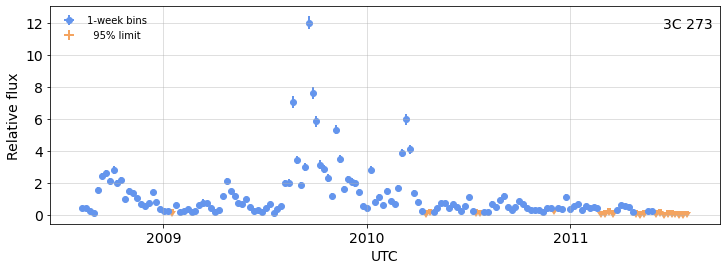

In [ ]:
if config.valid: 
    wtl.plot(UTC=1);

This assumes that the name for the source, in this case the historically famous first [quasar](https://en.wikipedia.org/wiki/Quasar#Background) to be discovered, can be associated with a 4FGL catalog source. The plot shows, as a function of UTC (or MJD if desired) time, weekly measurements of deviations of the flux relative to the average of the 12-year interval used to define the 4FGL-DR3 catalog.



## Overview

This package has code that was developed with the [nbdev](https://nbdev.fast.ai/) code/tests/documentation environment from the [github package lat-timing](https://github.com/tburnett/lat-timing) to generate light curves of Fermi-LAT sources.  
It is based on a [paper](https://arxiv.org/pdf/1910.00140.pdf) by Matthew Kerr, which derives the [weighted likelihood formalism](https://tburnett.github.io/wtlike/loglike#The-Kerr-likelihood-formula) used here, specifically with
the [Bayesian Block](https://arxiv.org/pdf/1207.5578.pdf) to detect and characterize variability of a gamma-ray source.

There are several innovative design features that significantly improve the speed and portability.

* Condensed photon and spacecraft data. 
* Weight tables
* A cache to improve interactivity
* Likelihood functions fit to a modified Poisson function
* Unbinned likelihood 
* A simple user interface


### How it works

Historically, gamma-ray source measurements have used two methods:
1. For a fixed time interval, where the energy and 
position are used, with a model including all potential sources and a model of the detector response to 
define the likelihood. This has been the only way to study weak sources. A light curve must apply this to
each time interval.
2. Or, for very bright flares, for example GRBs or AGN flares, one can simply count the number of photons within a
circular region, that is, aperture photometry.

Matthew Kerr [introduced](https://arxiv.org/pdf/1910.00140.pdf) a third method, basically counting photons but using information from a static
likelihood analysis to assign a "weight" to each photon, the probability for being from the source in question, then optimizing this likelihood. This assumes that the only thing changing is the flux of
the source.  He calls it "retrospective", since the analysis for the full time is then applied back to the individual photons. Another way of looking at it is to make the assumption that the time dependence of a source's photon flux factorizes according to the energy and spatitial dependences.  

### Likelihood evaluation

In a significant modification from Kerr's implemetation as described in that paper, we evaluate weights for each photon by a table lookup.

Assumptions:
* Source photons are completely contained in the dataset boundaries (the "ROI").
* The instrument response is constant with time.
* The background pattern is constant. (Clearly violated if a neighboring source varies!)

The likelihood evaluation is implemented in the module  [loglike](https://tburnett.github.io/wtlike/loglike).

### Photon Data

*Fermi* data are retrieved from the Fermi-LAT weekly data files extracted from the [GSFC FTP server](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly), 
with subfolders for the photon data, `photon` and spacecraft data, `spacecraft`. It is [described here](http://fermi.gsfc.nasa.gov/ssc/data/access/http://fermi.gsfc.nasa.gov/ssc/data/access/). The files are organized into individual weeks, starting UTC midnight each Thursday. Files for the most recent week are updated daily.

We convert each pair of photon and spacecraft files to two DataFrame tables with the minimum information needed to evaluate the likelihood, as compressed as possible. Particularly, the energy and position are binned. Details can be seen in the module [data_man](https://tburnett.github.io/wtlike/data_man).  

The entire data set (SOURCE class, energy>100 MeV) in this format occupies ~2 GB.

### Select Data for a source

All further processing uses a subset of the photons within a cone, currently $4^\circ$, about the selected source, and 
evaluates the exposure during 30-s intervals for this direction.  In the class
[`SourceData`](https://tburnett.github.io/wtlike/source_data#SourceData), implemented in the module 
[`source_data`](https://tburnett.github.io/wtlike/source_data) we
1. Extract photons
2. Evaluate exposure, using the effective area tables and a spectral assumption.
3. Determine the weight for each photon, using the table for the source. See the module [weights](https://tburnett.github.io/wtlike/weights) for details.

The result is a photon DataFrame, containing for each photon, the time $t$ in MJD units, $w$.

This class is a superclass of the user interface class `WtLike` introduced above.

### Partition into cells

A "cell", the terminology used by Kerr, the set of photons in a specific time interval. The class 
[CellData](https://tburnett.github.io/wtlike/cell_data#CellData)
in the module [cell_data](https://tburnett.github.io/wtlike/cell_data), a subclass of SourceData manages this.

This class is instantiated with a tuple to define the binning in time. Denoted by `(a, b, c)`, the elements are:
* `a`--start time 
* `b`--stop time
* `c`-- bin size in days, but 0 means orbit-based, intervals are contiguous eposure.

For the start and stop, values > 50000 are interpreted as MJD. Otherwise they are relative to start if positive
or stop if negative for the full dataset, both rounded to a full day. Zero means actual start for `a` and stop for `b`.
The default binning is simply `(0, 0, 7)` for weekly bins with the full dataset. Hourly for the most recent week would be `(-7, 0, 1/24)`.

A DataFrame table of the cells is created as a data member `cells`, with content

* `t` -- MJD time at cell center
* `tw` -- cell width in days
* `e` -- cell exposure, for reference 
* `n` -- the number of photons
* `w` -- a list of `n` weights
* `S` -- expected number source photons, the nominal source rate times the total exposure.
* `B` -- expected number of background photons (unused)

### Views

`CellData` implements a method `view`, which accepts a binning tuple as an argument, returns a *copy* of the current object, which can be a subclass, assigning to it the binning. Thus the view has all the attributes of its parent, but
with a different set of cells. 

So the following creates a new WtLike object that we generated above, rebins a copy with 25-day bins in the first 100 days, generates a list of the cells, then removes it since it wasn't assigned a reference variable.


In [ ]:
if config.valid:
    print(wtl.view(0,100,25).cells)

CellData.rebin: Bin photon data into 4 25-day bins from 54683.0 to 54783.0
LightCurve: select 4 cells for fitting with e>125 & n>2
         t    tw            e     n  \
0  54695.5  25.0  1488.182373   553   
1  54720.5  25.0  1868.273926  1438   
2  54745.5  25.0  1450.828979  1183   
3  54770.5  25.0  1929.570801  1175   

                                                   w           S           B  
0  [4.8901367e-01, 0.8066406, 0.11303711, 0.19165...  300.871887  532.046936  
1  [0.4345703, 0.6064453, 0.0690918, 0.056274414,...  377.716553  667.935242  
2  [0.33911133, 0.3100586, 0.7089844, 0.06994629,...  293.320007  518.692566  
3  [0.09112549, 0.58251953, 0.07537842, 0.3457031...  390.109192  689.849792  


### Evaluate Likelihoods and make light curve plots

The class [`LightCurve`](https://tburnett.github.io/wtlike/lightcurve), implemented in the module [`lightcurve`](https://tburnett.github.io/wtlike#LightCurve) is a subclass of `SourceData`.
An instance invokes its superclass to generate the set of cells, then evaluates the likelihoods.

#### Poisson-like Likelihood
We fit the likelihood for each cell, using only a few evaluations, to a [3-parameter Poisson-like formula](https://tburnett.github.io/poisson). Two advantages of this are:
* efficiency -- for large numbers of photons, this is much faster
* convenience -- the [`Poisson`](https://tburnett.github.io/wtlike/poisson.html#Poisson) object implements functions that return the TS, 95% CL, maximum, and uncertainties, using the [incomplete gamma function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html).

This results in a DataFrame `fits` containing
* `t, tw, n`, from the cell, and
* `fit`, the `Poisson` object

#### Light curve plots

The function `Likelihood.plot` actually invokes [`flux_plot`](https://tburnett.github.io/lightcurve#flux_plot)

### Apply Bayesian Blocks
The class [`WtLike`](https://tburnett.github.io/wtlike/90-main.html#WtLike), 
implememted in the module [`main`](https://tburnett.github.io/wtlike/90-main.html), adds an implementation of the Bayesian Block (BB) algorithm, from the module [`bayesian`](https://tburnett.github.io/wtlike)  using likelihood instead of counts.
There we have two subclasses of `astropy.stats.bayesian_blocks`, [`CountFitness`](https://tburnett.github.io/wtlike/bayesian.html#CountFitness) and the default [`LikelihoodFitness`](https://tburnett.github.io/wtlike/bayesian.html#LikelihoodFitness).
    
This code creates partitions between boundaries of a set of cells. Usage is via a special view, 
[bb_view`](https://tburnett.github.io/wtlike/main#WtLike.bb_view)
                     

Bayesian Blocks: partitioning 156 cells using LikelihoodFitness with penalty 5%
	found 43 / 156 blocks.
LightCurve: Loaded 43 / 43 cells for fitting


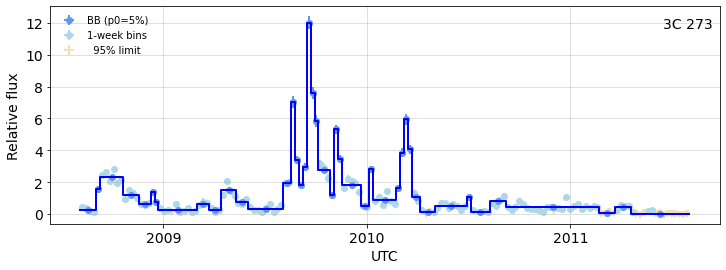

In [ ]:
if config.valid:
    bb = wtl.bb_view()
    bb.plot(UTC=1);

As you see, this made 94 blocks from the 656 weeks, fit each, and overplotted in on the weekly light curve.

### Kerr Periodogram

One can analyze the frequency spectrum by generating a 
[Kerr periodogram](https://arxiv.org/pdf/1910.00140.pdf). 
A `WtLike` object has a `periodogram` function that returns a `TimeSeries` object.
<details  class="nbdoc-description" >  <summary> Setup output </summary>  <div style="margin-left: 5%;"><pre>CellData.rebin: Bin photon data into 26256 1-hour bins from 54683.0 to 55777.0<br></pre></div> </details>
<figure style="margin-left: 5%" title="Figure 1">   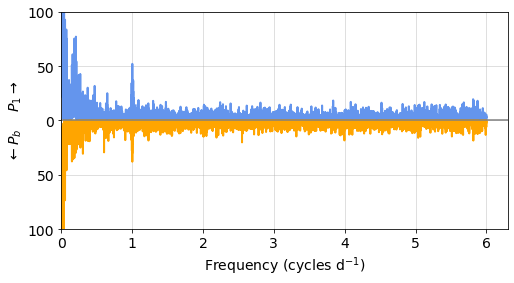 </figure>


In [ ]:
# collapse-hide

@ipynb_doc
def pgram(wtl):
    """
    ### Kerr Periodogram

    One can analyze the frequency spectrum by generating a 
    [Kerr periodogram](https://arxiv.org/pdf/1910.00140.pdf). 
    A `WtLike` object has a `periodogram` function that returns a `TimeSeries` object.
    {out}
    {fig}
    """
    with capture_hide('Setup output') as out:
        p =wtl.periodogram()
        p.power_plot(pmax=100 );
    fig = plt.gcf()
    return locals()

if config.valid: pgram(wtl)

## Aitoff and ZEA projections of a HEALPix map

Choose week 79, with a large 3C 454.3 flare.

The all-sky Aitoff image of the photon count map, counts per nside=64 pixel.
<figure style="margin-left: 5%" title="Figure 1">   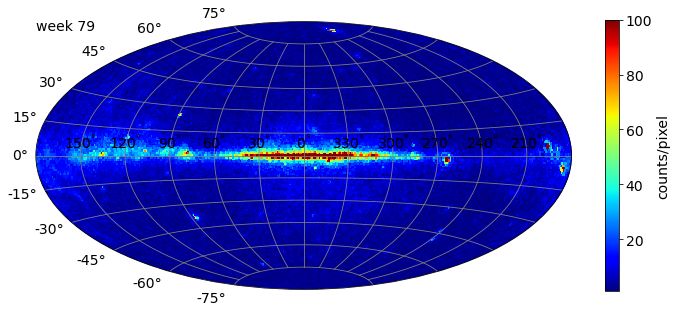 </figure>

And zoom to small region, with a ZEA projection, a $40^\circ$ square.
<figure style="margin-left: 5%" title="Figure 2">   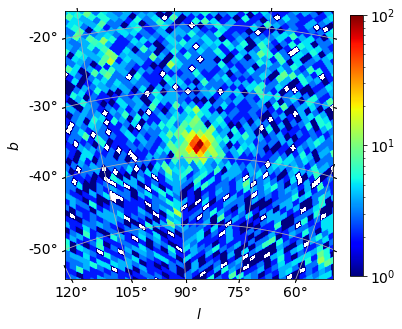 </figure>


In [ ]:
# collapse-hide

@ipynb_doc
def aitdemo(week, nside, name='3C 454.3', size=40):
    """
    ## Aitoff and ZEA projections of a HEALPix map
    
    Choose week {week}, with a large 3C 454.3 flare.
    
    The all-sky Aitoff image of the photon count map, counts per nside={nside} pixel.
    {fig1}
    
    And zoom to small region, with a ZEA projection, a ${size}^\circ$ square.
    {fig2}
    """
    from wtlike.skymaps import  SquareWCS
    from wtlike.sources import findsource
    from utilities import healpix as hpx
    
    cntmap = DataView( FermiInterval(7)[week-1], nside=nside).count_map()
    
    kw = dict(vmin=1, vmax=100, )
    fig1 = hpx.HPmap(cntmap, f'week {week}', unit='counts/pixel', sigma=0.5).ait_plot(**kw);
    
    wcs = SquareWCS(findsource(name, gal=True), size=size,)
    fig2 = wcs.plot(cntmap, name, 
          cb_kw=dict( shrink=0.8), **kw)
    return locals()


week=79
nside=64

if valid: aitdemo(week, nside, fignum=1)

## Simulation

Finally, a simulation option is available. See the [tutorial](https://tburnett.github.io/wtlike/tutorial/)  for an example

## Installation

Note that this is in beta mode. 
It depends on the packages:  matplotlib, pandas, scipy, astropy, scipy and healpy, which pip will install if needed.

To install from pyPI:

```
pip install wtlike
```
or to upgrade:
```
pip install -U wtlike
```


## Input data

There are three data sources which `wtlike` needs to function:

-	The photon/spacecraft data, one file per week
-	A table of weights for each source
-	An effective area table, a grid in energy/angle for "front" and "back" events 

These must be found in a folder, which by default is `~/wtlike-data`. In that folder there must be (perhaps links to) three folders named `data_files`, `weight_files`, `aeff_files`, and a zip file, `weight_file.zip`.  A current copy can be found in my [Google Drive](https://drive.google.com/drive/folders/1YxQRpZ4MI945-GZ2bK3CgTo6ViqoQ2Xt?lfhs=2).

## Google colab setup

An easy way to test, or even use, this system is with [Goggle's colab](https://colab.research.google.com/). To use it, you need a Google account.
All the data files are in my shared folder [wtlike-data](https://drive.google.com/drive/folders/1YxQRpZ4MI945-GZ2bK3CgTo6ViqoQ2Xt?lfhs=2).
It includes a [setup notebook](https://colab.research.google.com/drive/1Dy29VRE3M28W_uMJruDxrBElFpyg0Iyl) which demonstrates setting up a free Google-hosted VM to run wtlike code and makes a few demo plots.